In [1]:
# パッケージのimport
%matplotlib inline

import re

import glob
import os
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import shap

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

## 01. データの前処理を行うTransformクラス

In [2]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'test': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [3]:
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """
    
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize), # 短い編の大きさが resize の大きさになる
            transforms.CenterCrop(resize), # 画像中央を resize × resize で切り取り
            transforms.ToTensor(), # テンソルへ変換
            transforms.Normalize(mean,std) # 色情報を標準化
        ])
    
    def __call__(self, img, phase = 'train'):
        return self.base_transform(img)

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = BaseTransform(resize, mean, std)

## 02. 入力ファイルリストを作成する関数の定義

In [4]:
# アリとハチの画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = os.path.join(".","data")
    target_path = os.path.join(rootpath , phase,"**","*.jpg")
#     print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
test_list = make_datapath_list(phase="test")

## 03. データセットクラス

In [9]:
class PaintersDateset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''
        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        if len(np.array(img).shape) == 2:
            img = img.convert('RGB')
        
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])へ変換

        # 画像のラベルをファイル名から抜き出す
        label = os.path.basename(os.path.dirname(img_path))

        # ラベルを数値に変更する
        artist_label_dict =  {"Vincent_van_Gogh" : 0,
                              "Edgar_Degas": 1,
                              "Pablo_Picasso": 2,
                              "Pierre-Auguste_Renoir":3,
                              "Albrecht_Durer": 4,
                              "Paul_Gauguin":5,
                              "Francisco_Goya": 6,
                              "Rembrandt": 7,
                              "Alfred_Sisley":8,
                              "Titian": 9,
                              "Marc_Chagall":10}
        label = artist_label_dict.get(label)
            
        return img_transformed, label


# 実行

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = PaintersDateset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

test_dataset = PaintersDateset(
    file_list=test_list, transform=ImageTransform(size, mean, std), phase='test')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
4


In [96]:
artist_label_dict =  {"Vincent_van_Gogh" : 0,
                      "Edgar_Degas": 1,
                      "Pablo_Picasso": 2,
                      "Pierre-Auguste_Renoir":3,
                      "Albrecht_Durer": 4,
                      "Paul_Gauguin":5,
                      "Francisco_Goya": 6,
                      "Rembrandt": 7,
                      "Alfred_Sisley":8,
                      "Titian": 9,
                      "Marc_Chagall":10}

artist_label_dict_decode = {}

for k, v in artist_label_dict.items():
    temp_key = k
    if re.search('_([A-Za-z]*)', k):
        for r in re.finditer('_([A-Za-z]*)', k):
            temp_key = r.group(1)
    artist_label_dict_decode[v] = temp_key
artist_label_dict_decode

print("Marc_Chagall" in artist_label_dict)
print(artist_label_dict.get("me"))

True
None


## 04. データローダの定義

In [158]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "test": test_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([ 9,  5,  7,  4,  6,  9,  7,  5,  0,  5,  5,  4,  5,  5,  1,  2,  8, 10,
         0,  3,  4,  4,  1,  5,  0, 10,  3,  6,  7,  5,  6,  1])


In [11]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=11)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [12]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [13]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)


params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [14]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)


In [15]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'test']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
                del inputs
                del labels
                torch.cuda.empty_cache()


            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [16]:
# 学習・検証を実行する
num_epochs = 10
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch 1/10
-------------


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 2.4372 Acc: 0.0864
Epoch 2/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 1.6836 Acc: 0.4420


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 1.0324 Acc: 0.6705
Epoch 3/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.9285 Acc: 0.6955


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 0.8496 Acc: 0.7182
Epoch 4/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.6855 Acc: 0.7648


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 0.7963 Acc: 0.7068
Epoch 5/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.5849 Acc: 0.8057


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 0.7460 Acc: 0.7364
Epoch 6/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.4770 Acc: 0.8386


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 0.6403 Acc: 0.7750
Epoch 7/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.4210 Acc: 0.8568


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 0.7033 Acc: 0.7659
Epoch 8/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.3765 Acc: 0.8727


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 0.5880 Acc: 0.7864
Epoch 9/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.2892 Acc: 0.8972


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

test Loss: 0.6128 Acc: 0.7909
Epoch 10/10
-------------


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

train Loss: 0.3058 Acc: 0.8835


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.19it/s]

test Loss: 0.6143 Acc: 0.7795


## Shap

In [188]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_dataloader))
images, labels = batch

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
net.to(device)

images = images.to(device)

n_cut = 24

background = images[:n_cut]
test_images = images[n_cut:batch_size]

e = shap.DeepExplainer(net, background)

shap_values = e.shap_values(test_images)

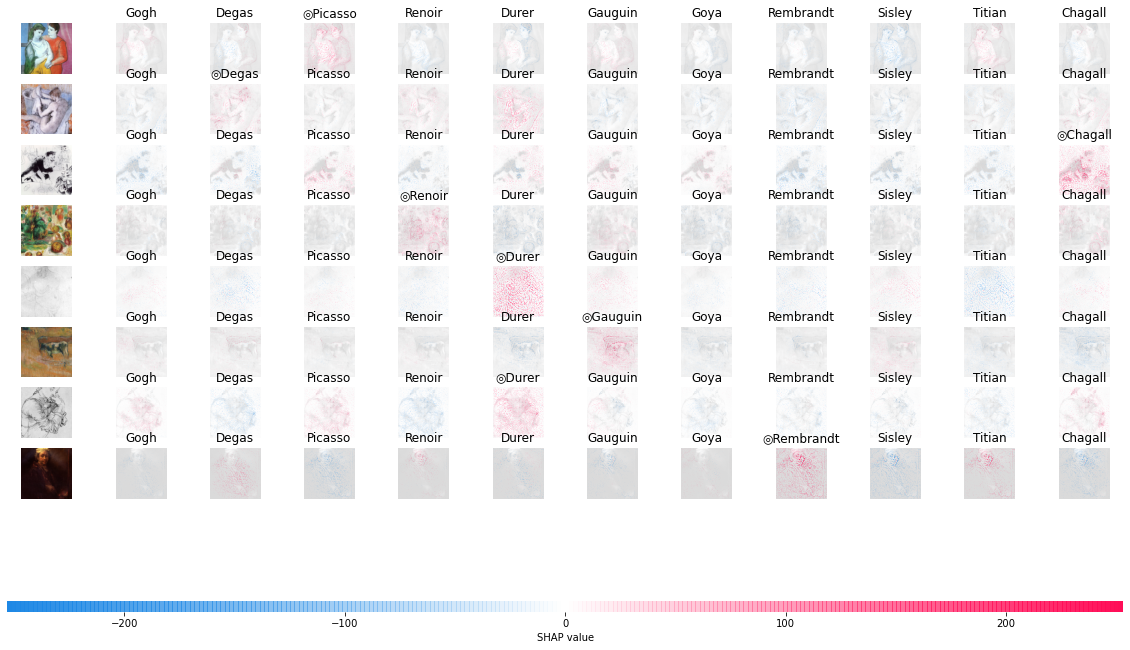

In [193]:
def pn_label(predict_i,label_j,k):
    '''
    predict : ☆　label:"★ current : ◎
    '''
    if predict_i == label_j == k:
        return "◎"
    elif predict_i == k:
        return "☆"
    elif label_j == k:
        return "★"
    else:
        return ""


shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
test_numpy = test_numpy * std + mean
# test_numpy = test_numpy/np.amax(test_numpy)
test_numpy = np.clip(test_numpy
                     
                     ３８１８, 0, 1)

outputs = net(test_images).max(1)
predict = outputs[1].to('cpu').detach().numpy().copy()

predict_numpy = np.array([[f"{pn_label(predict[j],labels[n_cut + j].to('cpu').detach().numpy().copy(),i)}\
{artist_label_dict_decode[i]}"  \
                           for i in range(0,11)] for j in range(0, batch_size - n_cut)])

shap.image_plot(shap_numpy, test_numpy ,predict_numpy)